## Basic operations with Atmospheric data on native grid

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/eunbyeol/MPI/scheduler.json')  
client

<Client: 'tcp://203.247.189.224:46596' processes=7 threads=126, memory=586.73 GiB>

In [2]:
import xarray as xr
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmcrameri.cm as cm 

In [4]:
model = 'awicm3-TCo319'
expid = 'TCo319-DART' 
version = 'ctl1950d-gibbs-charn'
realm = 'oifs'
base_p = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"

In [5]:
model = 'awicm3-TCo319'
expid = 'TCo319-DART' 
version = 'ssp585d-gibbs-charn'
realm = 'oifs'
base_f = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"


In [6]:
files = glob.glob(os.path.join(base_f, "*.nc"))

unique_vars = set()

pattern = re.compile(r"atm_remapped_(.+?)_(?:\d+[hdm](?:_pl)?)_\d{4}-\d{4}\.nc$")

for f in files:
    fname = os.path.basename(f)
    m = pattern.match(fname)
    if m:
        unique_vars.add(m.group(1))
result_list = sorted(unique_vars)
print(result_list)

['1d_10u', '1d_10v', '1d_2t', '1d_cp', '1d_ewss', '1d_hcc', '1d_lcc', '1d_lsp', '1d_mcc', '1d_mn2t', '1d_msl', '1d_mx2t', '1d_nsss', '1d_slhf', '1d_sshf', '1d_ssr', '1d_ssrc', '1d_str', '1d_strc', '1d_tcc', '1d_tsr', '1d_tsrc', '1d_ttr', '1m_10u', '1m_10v', '1m_2d', '1m_2t', '1m_asn', '1m_ci', '1m_cp', '1m_e', '1m_ewss', '1m_fal', '1m_hcc', '1m_istl1', '1m_lcc', '1m_lnsp', '1m_lsp', '1m_mcc', '1m_mn2t', '1m_msl', '1m_mx2t', '1m_nsss', '1m_pl_cc', '1m_pl_ciwc', '1m_pl_clwc', '1m_pl_o3', '1m_pl_q', '1m_pl_r', '1m_pl_t', '1m_pl_u', '1m_pl_v', '1m_pl_w', '1m_pl_z', '1m_ro', '1m_rsn', '1m_sd', '1m_sf', '1m_skt', '1m_slhf', '1m_sshf', '1m_ssr', '1m_ssrc', '1m_ssrd', '1m_sst', '1m_stl1', '1m_stl2', '1m_stl3', '1m_stl4', '1m_str', '1m_strc', '1m_strd', '1m_swvl1', '1m_swvl2', '1m_swvl3', '1m_swvl4', '1m_tcc', '1m_tciw', '1m_tclw', '1m_tcw', '1m_tcwv', '1m_tisr', '1m_tsn', '1m_tsr', '1m_tsrc', '1m_ttr', '1m_ttrc', '6h_10u', '6h_10v', '6h_2t', '6h_hcc', '6h_lcc', '6h_mcc', '6h_msl', '6h_pl_ciwc'

In [7]:
# -------------------
# Get file list
# -------------------
files_f = os.listdir(base_f)
files_p = os.listdir(base_p)

In [8]:
# -----------------------
# Target variable for AG
# -----------------------
# target = "1d_2t"
# target = "1d_cp"
# target = "1d_lsp"
# target = "1d_10u"
# target = "1d_10v"

# -------------------
# Target period
# -------------------
p_start_year = 1950
p_end_year = 1959
f_start_year = 2080
f_end_year = 2089


In [9]:
# periods = {
#     "past": (1950, 1959),
#     "future": (2080, 2089)
# }

In [10]:
# -------------------
# 1) YEAR RANGE FUNCTION (FIXED)
# -------------------
def extract_year_range(fname):
    m = re.search(r'_(\d{4})-(\d{4})\.nc$', fname)
    if m:
        y1 = int(m.group(1)[0:4])
        y2 = int(m.group(2)[0:4])
        return y1, y2
    return None, None   

In [11]:
def select_files(files, base, target, start_year, end_year):
    selected = [
        os.path.join(base, f)
        for f in sorted(files) if target in f
        for y1, y2 in [extract_year_range(f)]
        if y1 is not None and (y2 >= start_year) and (y1 <= end_year)
    ]
    return selected

In [12]:
def open_dataset(files):
    ds = xr.open_mfdataset(files, combine='by_coords', parallel=True, chunks={"time": 100})
    print(ds.dims)
    print(ds.data_vars)
    return ds


In [13]:
def select_variable(ds, var_key, start_year, end_year):
    """Select variable from dataset and slice by time."""
    if var_key not in ds:
        raise KeyError(f"Variable {var_key} not found. Available: {list(ds.data_vars.keys())}")
    
    da = ds[var_key]
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    da_sel = da.sel({time_dim: slice(f"{start_year}-01-01", f"{end_year}-12-31")})
    
    return da_sel

In [14]:
def compute_mean(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    return da.mean(dim=time_dim).compute()

In [15]:
def compute_std(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    return da.std(dim=time_dim).compute()

In [16]:
def compute_std_anomaly(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    
    # remove leaf day
    da_noleap = da.sel({time_dim: ~((da[time_dim].dt.month==2) & (da[time_dim].dt.day==29))})
    
    # daily climatology
    clim = da_noleap.groupby(f"{time_dim}.dayofyear").mean(dim=time_dim)
    
    # anomaly
    anom = da_noleap.groupby(f"{time_dim}.dayofyear") - clim
    
    # std
    from dask.diagnostics import ProgressBar
    with ProgressBar():
        return anom.std(dim=time_dim).compute()


In [17]:
def open_and_select(files, base, target, start_year, end_year):
    var_key = target.split("_", 1)[1]
    sel_files = select_files(files, base, target, start_year, end_year)
    print(f"Selected files for {target} ({start_year}-{end_year}):", sel_files)

    ds = open_dataset(sel_files)
    da = select_variable(ds, var_key, start_year, end_year)
    return da

In [18]:
# Target
target1 = "1d_cp"
var_key1 = target1.split("_", 1)[1]   # "2t"
# Get DA (no mean yet)
# ---- Load data (p, f separately) ----
da_p1 = open_and_select(files_p, base_p, target1, p_start_year, p_end_year)
da_f1 = open_and_select(files_f, base_f, target1, f_start_year, f_end_year)

Selected files for 1d_cp (1950-1959): ['/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1950-1950.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1951-1951.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1952-1952.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1953-1953.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1954-1954.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1955-1955.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1956-1956.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1957-1957.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_cp_1d_1958-1958.nc'

In [19]:
# ---- Compute mean ----
da_mean_p1 = compute_mean(da_p1)
da_mean_f1 = compute_mean(da_f1)

# ---- Compute std with anomaly ----
da_std_ano_p1 = compute_std_anomaly(da_p1)
da_std_ano_f1 = compute_std_anomaly(da_f1)
# ---- Compute std ----
da_std_p1 = compute_std(da_p1)
da_std_f1 = compute_std(da_f1)

In [20]:
# Target
target2 = "1d_lsp"
var_key2 = target2.split("_", 1)[1]   # "2t"
# Get DA (no mean yet)
# ---- Load data (p, f separately) ----
da_p2 = open_and_select(files_p, base_p, target2, p_start_year, p_end_year)
da_f2 = open_and_select(files_f, base_f, target2, f_start_year, f_end_year)

Selected files for 1d_lsp (1950-1959): ['/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1950-1950.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1951-1951.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1952-1952.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1953-1953.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1954-1954.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1955-1955.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1956-1956.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_1957-1957.nc', '/scratch/awicm3-TCo319/TCo319-DART-ctl1950d-gibbs-charn/outdata/oifs/atm_remapped_1d_lsp_1d_195

In [21]:
# ---- Compute mean ----
da_mean_p2 = compute_mean(da_p2)
da_mean_f2 = compute_mean(da_f2)

# ---- Compute std with anomaly ----
da_std_ano_p2 = compute_std_anomaly(da_p2)
da_std_ano_f2 = compute_std_anomaly(da_f2)
# ---- Compute std ----
da_std_p2 = compute_std(da_p2)
da_std_f2 = compute_std(da_f2)

## Figures

In [29]:
long_name1 = da_p1.attrs.get("long_name", None)
print(long_name1)

long_name2 = da_p2.attrs.get("long_name", None)
print(long_name2)

Convective precipitation
Large-scale precipitation


In [30]:
lat = da_mean_p1['lat'].values      # (640,)
lon = da_mean_p1['lon'].values 

In [33]:
import os

folder_name = "../figure_Hackathon2025_AG/step02_319"     # figure folder         
save_dir = os.path.join(os.getcwd(), folder_name)  
os.makedirs(save_dir, exist_ok=True)             


In [51]:
# mean - only CP
hist1 = da_mean_p1.values*4000           
fut1  = da_mean_f1.values*4000
diff1 = fut1 - hist1

# mean - only lsP
hist2 = da_mean_p2.values*4000           
fut2  = da_mean_f2.values*4000
diff2 = fut2 - hist2

# mean - TP = cp+lsP
hist_tp = hist1 + hist2        
fut_tp  = fut1 + fut2
diff_tp = fut_tp - hist_tp
long_name="Total Precipitation"

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/step02_319/cp_mean_TCo319-DART.png


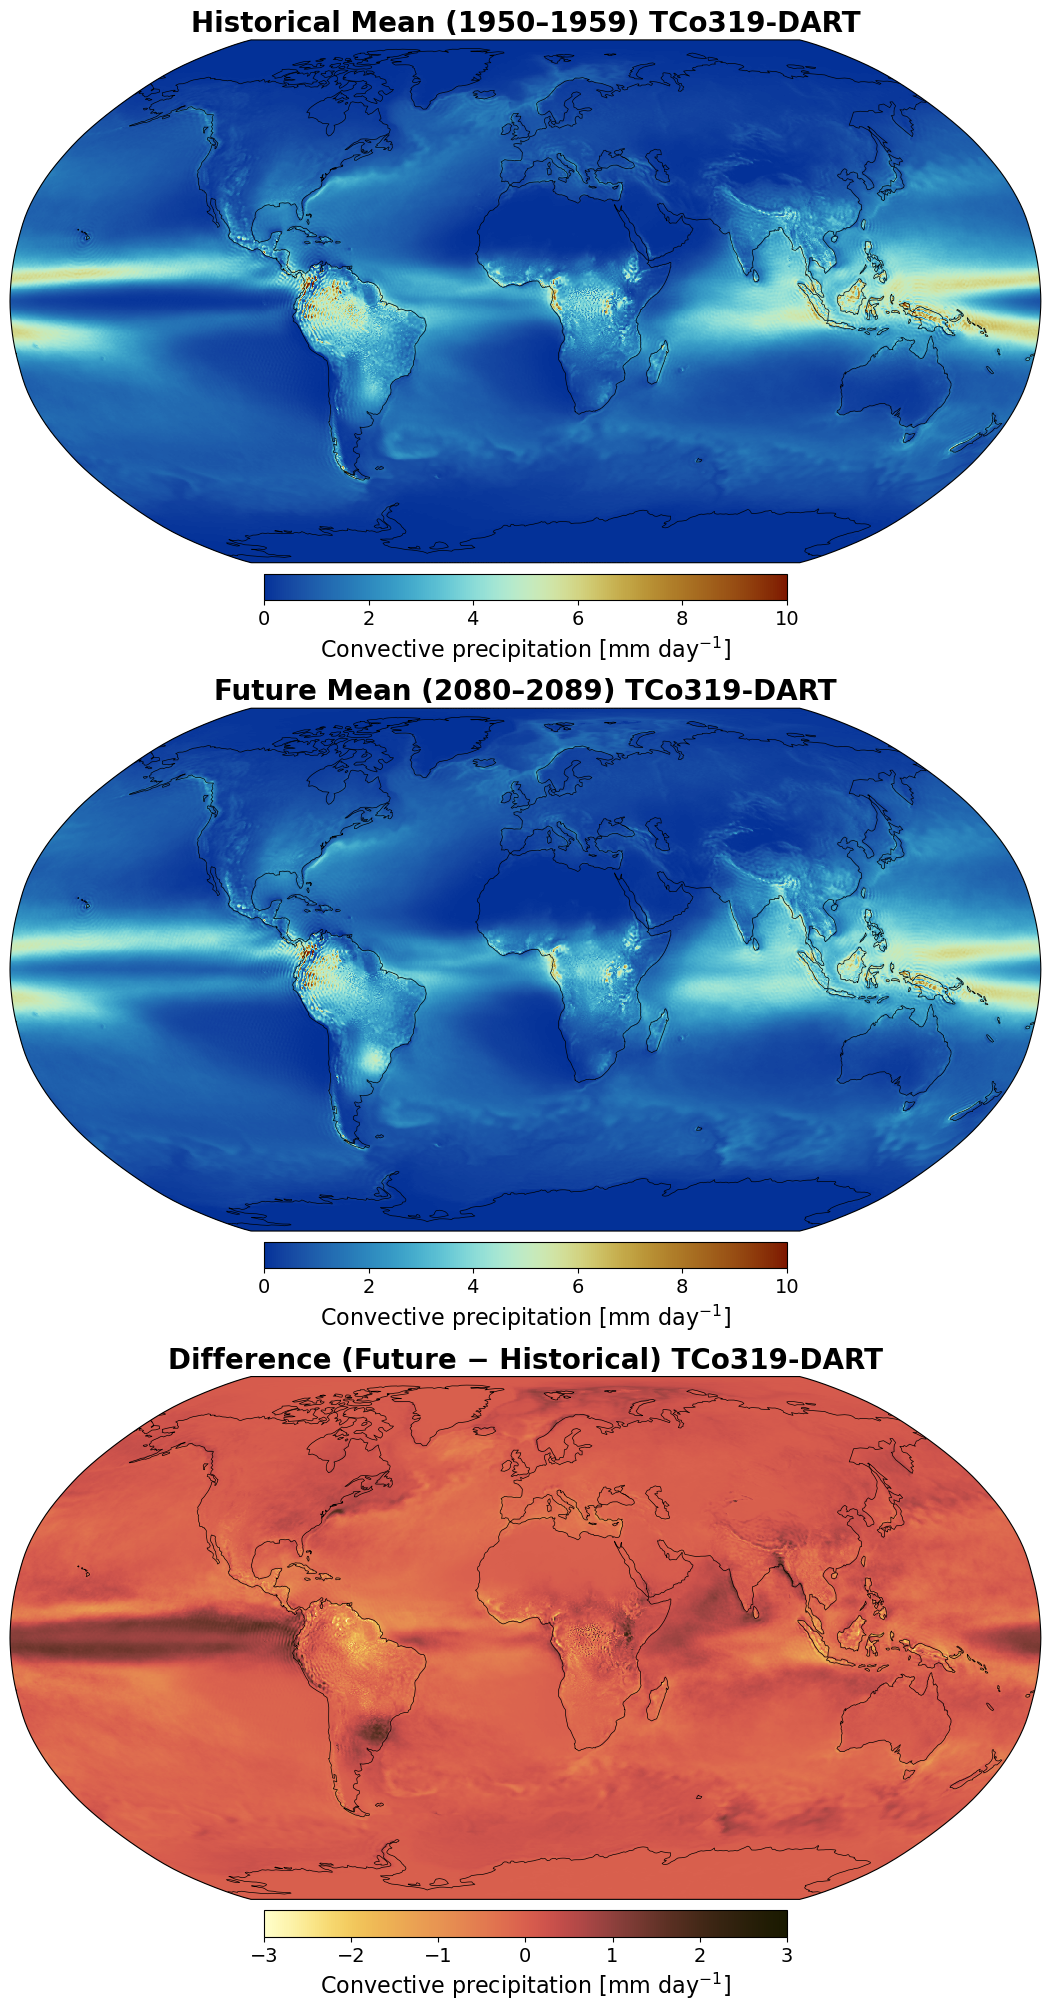

In [56]:
# CP
hist = hist1          
fut  = fut1
diff = fut - hist
long_name = long_name1
var_key = var_key1

c_ranges = [(0, 10), (0, 10), (-3, 3)]

datasets = [hist, fut, diff]
titles = [
    f'Historical Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

# meshgrid 만들기
lon2d, lat2d = np.meshgrid(lon, lat)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    # pcolorm으로 지도에 데이터 표시
    im = ax.pcolormesh(
        lon2d, lat2d, data,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto',       
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r 
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    # cbar.set_label(long_name if title != "Difference (Future − Historical)" else "Convective precipitation",
    #                size='16')
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16'
    )

save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/step02_319/lsp_mean_TCo319-DART.png


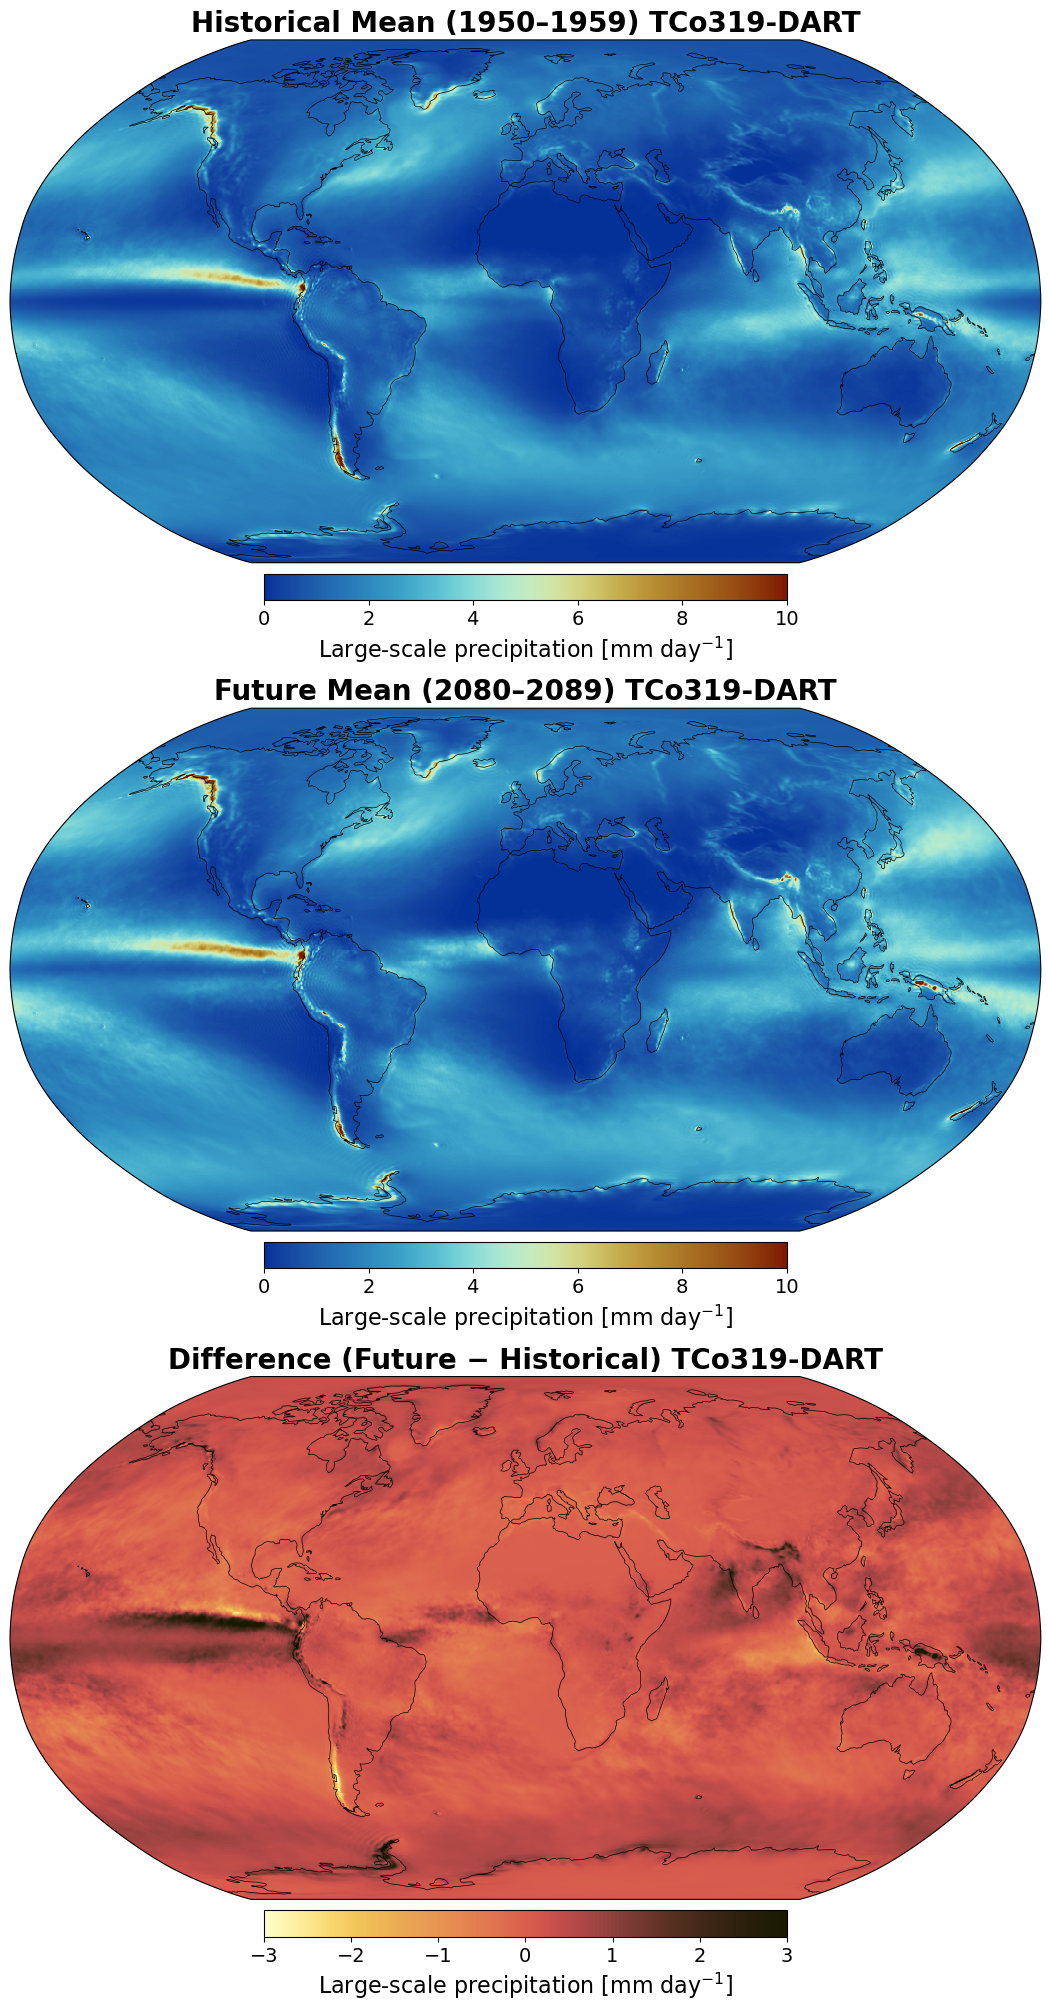

In [58]:
# LSP
hist = hist2           
fut  = fut2
diff = fut - hist
long_name = long_name2
var_key = var_key2

c_ranges = [(0, 10), (0, 10), (-3, 3)]

datasets = [hist, fut, diff]
titles = [
    f'Historical Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

# meshgrid 만들기
lon2d, lat2d = np.meshgrid(lon, lat)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    # pcolorm으로 지도에 데이터 표시
    im = ax.pcolormesh(
        lon2d, lat2d, data,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto',       
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r 
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16')

save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/step02_319/TP_mean_TCo319-DART.png


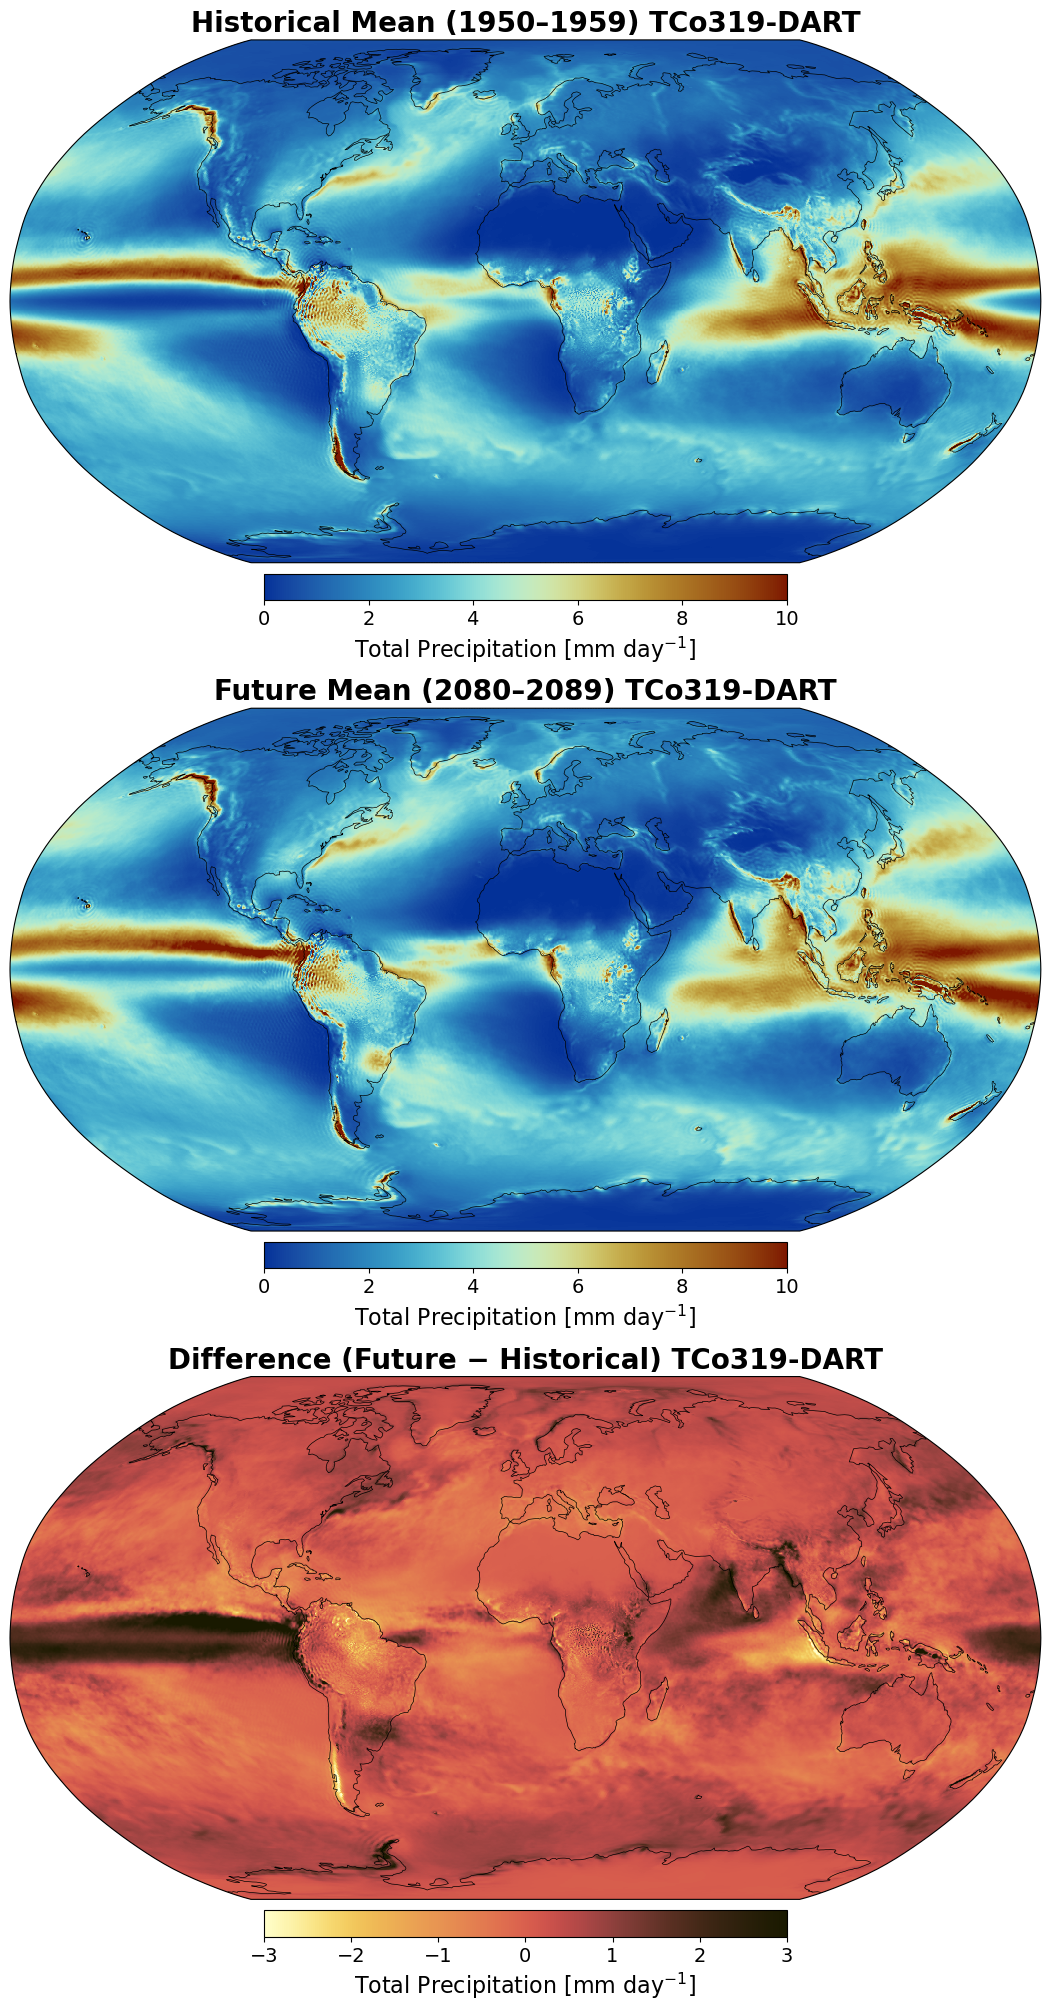

In [59]:
# Total 
hist = hist_tp         
fut  = fut_tp
diff = fut - hist
long_name='Total Precipitation'
var_key = 'TP'

c_ranges = [(0, 10), (0, 10), (-3, 3)]

datasets = [hist, fut, diff]
titles = [
    f'Historical Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

# meshgrid 만들기
lon2d, lat2d = np.meshgrid(lon, lat)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    # pcolorm으로 지도에 데이터 표시
    im = ax.pcolormesh(
        lon2d, lat2d, data,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto',       
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r 
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16')

save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## STD

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/step02_319/TP_std_TCo319-DART.png


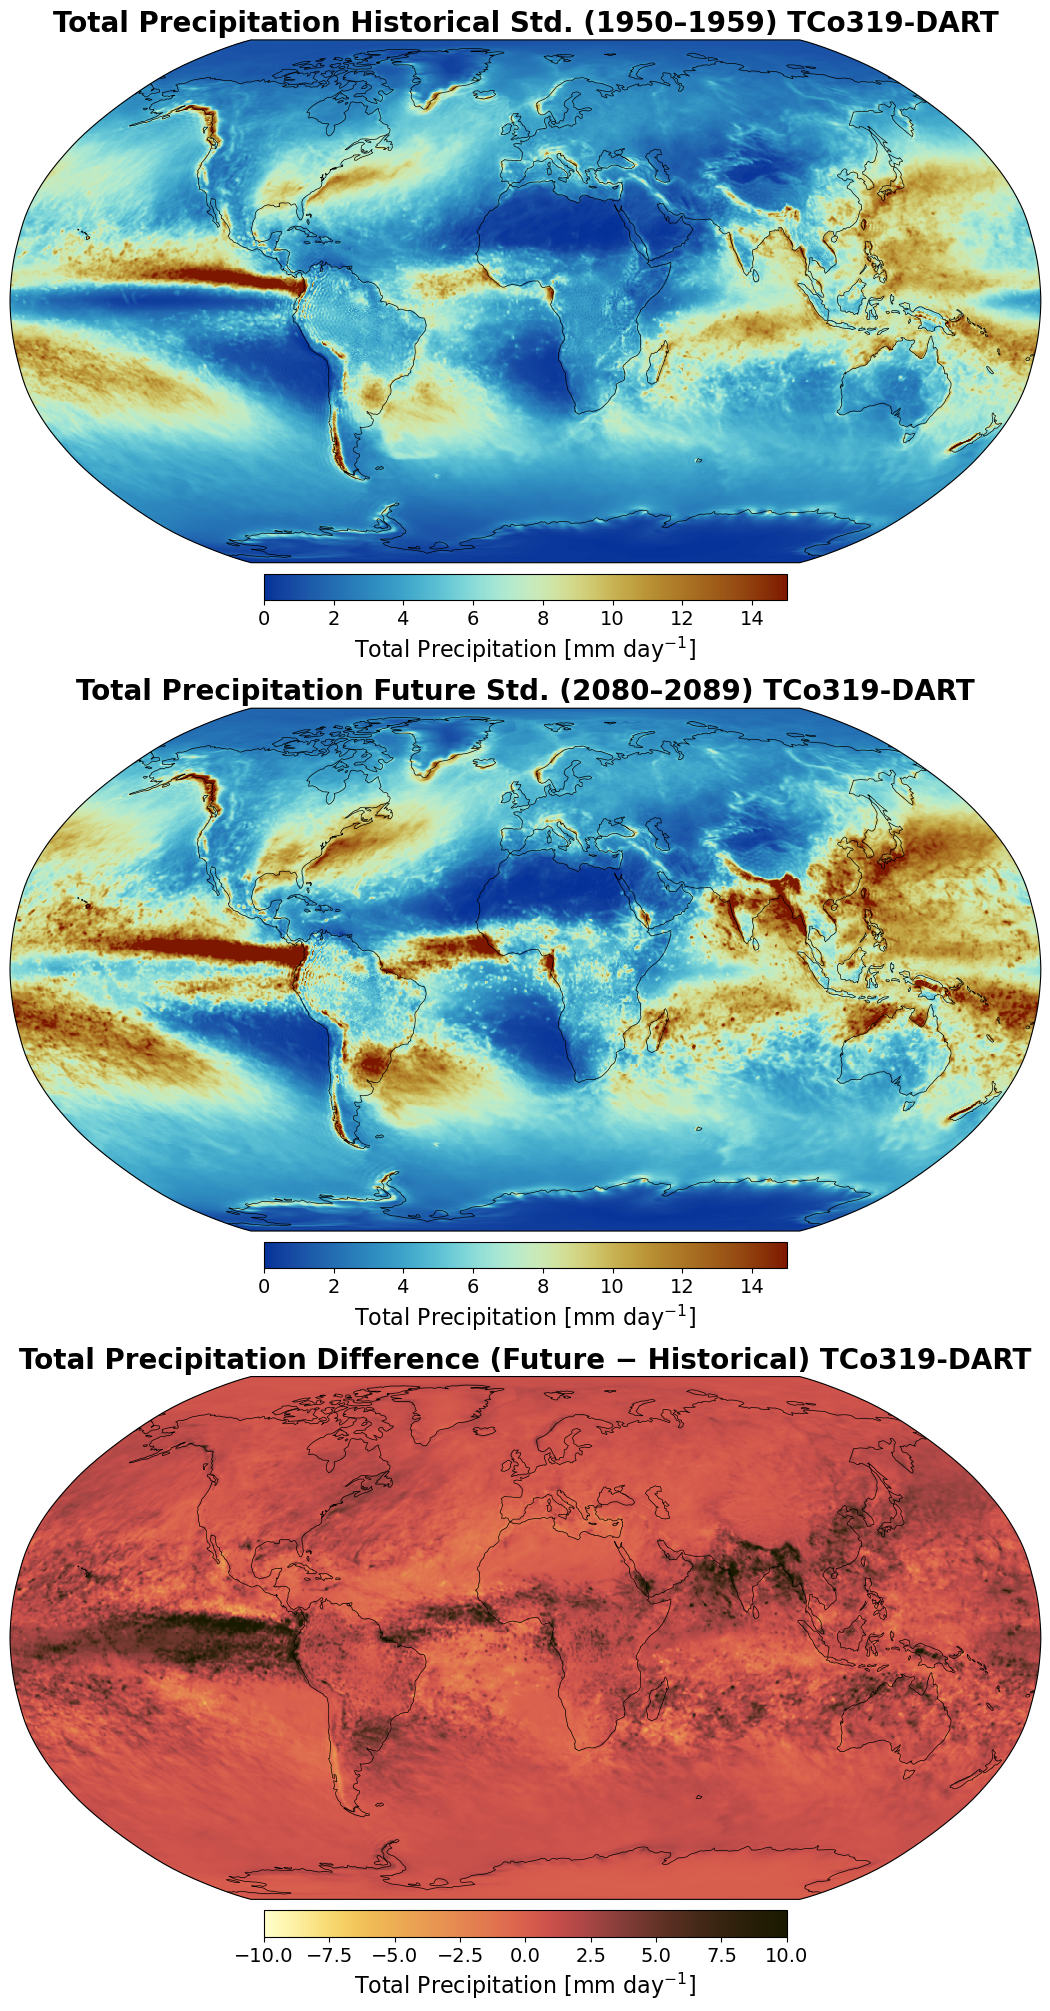

In [63]:
# Total 
hist = da_std_ano_p1.values + da_std_ano_p2.values          
fut  = da_std_ano_f1.values + da_std_ano_f2.values
hist = hist*4000
fut = fut*4000
diff = fut - hist
long_name='Total Precipitation'
var_key = 'TP'

c_ranges = [(0, 15), (0, 15), (-10, 10)]

datasets = [hist, fut, diff]
titles = [
    f'{long_name} Historical Std. (1950–1959) {expid}',
    f'{long_name} Future Std. (2080–2089) {expid}',
    f'{long_name} Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

# meshgrid 만들기
lon2d, lat2d = np.meshgrid(lon, lat)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    # pcolorm으로 지도에 데이터 표시
    im = ax.pcolormesh(
        lon2d, lat2d, data,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto',       
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r 
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16')

save_path = os.path.join(save_dir, f"{var_key}_std_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()